# Load and install packages

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf, seaborn as sns
import cv2 as cv, os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# EDA

In [2]:
img_dir = '/kaggle/input/computer-vision-advance/extracted_images'

Found 1016 images belonging to 3 classes.
Found 252 images belonging to 3 classes.


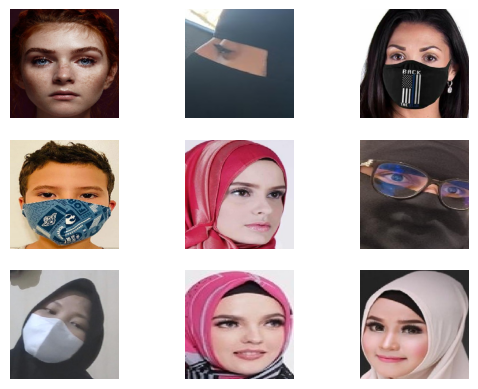

In [3]:
image_size = (224, 224)
batch_size = 32  

datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to range [0, 1]
    validation_split=0.2  # Split 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    img_dir,
    target_size=image_size,  # Resize images to uniform size
    batch_size=batch_size,
    class_mode='categorical',  # 3-class classification, so we use 'categorical'
    subset='training'         # This is the training subset
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    img_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # This is the validation subset
)

def plot_sample_images(generator):
    sample_images, sample_labels = next(generator)
    for i in range(9):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.show()

plot_sample_images(train_generator)

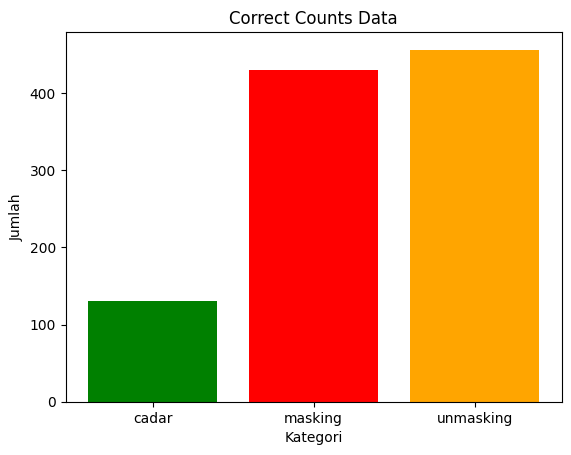

{'cadar': 130, 'masking': 430, 'unmasking': 456}


In [4]:
def count_images_per_class(generator):
    class_counts = {class_name: 0 for class_name in generator.class_indices}
    
    for i in range(len(generator.classes)):
        class_index = generator.classes[i] 
        class_name = list(generator.class_indices.keys())[class_index] 
        class_counts[class_name] += 1  

    return class_counts

def visualize_per_class(categories, values):
    colors = ['green', 'red', 'orange']
    plt.bar(categories, values, color=colors)
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah')
    plt.title('Correct Counts Data')
    plt.show()

train_class_counts = count_images_per_class(train_generator)
visualize_per_class(train_class_counts.keys(), train_class_counts.values())
print(train_class_counts)

Preprocess

In [5]:
def visualize_images(original, segment):
    # Create a figure to display the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original) 
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segment, cmap='gray')
    plt.title('Segmentation with KNN')
    plt.axis('off')

    # Show
    plt.tight_layout()
    plt.show()

def load_image(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
    return img

def segment_images_kmean(image, n_clusters):
    pixels = image.reshape(-1, 3)  

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype(int) 

    segmented_image = centers[labels].reshape(image.shape)  
    return segmented_image

def image_preprocessing(image_path):
    img = load_image(image_path)
    img_segmented = segment_images_kmean(img, 5)
    
    return img_segmented

def preprocess_and_save_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path): 
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)  
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                preprocessed_img = image_preprocessing(img_path)
                
                # Save
                output_img_path = os.path.join(output_class_path, img_name)
                cv.imwrite(output_img_path, preprocessed_img)
                
    print(f"Preprocessing complete. Preprocessed images saved in {output_dir}")


In [6]:
output_dir = '/kaggle/working/preprocess'
preprocess_and_save_images(img_dir, output_dir)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Preprocessing complete. Preprocessed images saved in /kaggle/working/preprocess
